In [1]:
import os
import sys 
import glob
import copy
import pyproj
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import xarray as xr
import xarray_sentinel
import drama.utils as drtls
import s1sea.geo_plot as gplt
from s1sea.cmod5n import cmod5n_inverse, cmod5n_forward
from s1sea.get_era5 import getera5
from s1sea.s1_preprocess import grd_to_nrcs, nrcs_to_roughness
from drama.performance.sar.antenna_patterns import sinc_bp
# importing from one directory  up
# sys.path.insert(0, "../" )
# from .misc import round_to_hour, angular_difference, calculate_distance

from dataclasses import dataclass
from typing import Callable, Union, List, Dict, Any
from velocity_leakage import S1DopplerLeakage

In [2]:
# TODO find out why 'Iceland_20231107' has discontinuity in predicted backscatter

In [3]:
data_dir = "/Users/opodriscoll/Documents/Data/Sentinel1/IW/"
storage_dir = "data_processed/"
scenarios = glob.glob(f"{data_dir}*")
scenarios = [scenario[scenario.rfind('/')+1:] for scenario in scenarios]
scenarios

['Carrib_20231104',
 'Azores_20201127',
 'Hawaii_20201106',
 'Barbedos_20201110',
 'Morroco_20201103',
 'Iceland_20231107',
 'Scotland_20231109']

In [4]:
# scenarios = ['Azores_20201127']

In [5]:
beam_pattern = "phased_array"

for scenario in scenarios:

    # ----------------------------------------
    files = glob.glob(f"{data_dir+scenario}/*.SAFE")

    test = S1DopplerLeakage(
        filename=files,    
        # era5_file='era5_winds/era5_wind_202011.nc',
        era5_directory= 'era5_winds/',
        scene_size=25_000,
        az_mask_cutoff=80_000,
        vx_sat=8000,
        PRF=4,
        resolution_spatial=100,
        length_antenna=3.2,
        beam_pattern=beam_pattern, # ["sinc", "phased_array"]
        )

    var_2_save = ['doppler_pulse_rg', 'V_leakage_pulse_rg', 'nrcs_scat', 'doppler_pulse_rg_subscene', 'V_leakage_pulse_rg_subscene', 'nrcs_scat_subscene']

    # ------------------- Compute scatterometer performance from Sentinel-1 ---------------------
    test.open_data()
    
    # copy the data at this step
    test_copy = copy.deepcopy(test)

    test.querry_era5()
    test.wdir_from_era5()
    test.create_dataset()
    test.create_beam_mask()
    test.compute_scatt_eqv_backscatter()
    test.compute_beam_pattern()
    test.compute_Doppler_leakage()

    storage_name_base = f"{storage_dir+scenario}_4ML_"
    storage_name_details = f"{beam_pattern}_la{str(test.length_antenna).replace('.', 'dot')}_vxsat{test.vx_sat}_PRF{test.PRF}_resspa{test.resolution_spatial}.nc"
    storage_name = storage_name_base + storage_name_details
    test.data[var_2_save].to_netcdf(storage_name)

    # ------------------- Interpolate scatterometer NRCS to Sentinel-1 resolution --------------------
    
    # NOTE check below
    idx_start = test.idx_az[0][test.az_mask_pixels_cutoff]
    idx_end = test.idx_az[-1][test.az_mask_pixels_cutoff]
    new_nrcs = np.nan*np.ones_like(test.S1_file.NRCS_VV)
    new_inc = np.nan*np.ones_like(test.S1_file.NRCS_VV)
    slow_time_upsamp = np.linspace(test.data.slow_time[0], test.data.slow_time[-1], idx_end - idx_start) # NOTE check in particular
    
    nrcs_scat_upsamp = test.data.nrcs_scat.T.interp(slow_time = slow_time_upsamp)
    inc_scat_upsamp = test.data.inc_scatt_eqv_cube.mean(dim='az_idx').T.interp(slow_time = slow_time_upsamp)

    new_nrcs[idx_start: idx_end, :] = nrcs_scat_upsamp
    new_inc[idx_start: idx_end, :] = inc_scat_upsamp

    test_copy.S1_file['NRCS_VV'] = (['azimuth_time', 'ground_range'], new_nrcs)#nrcs_scat_upsamp.T.values)
    test_copy.S1_file['inc'] = (['azimuth_time', 'ground_range'], new_inc)#inc_scat_upsamp.T.values)

    # ------------------- Estimate velocity leakage from scatteromter NRCS --------------------
    test_copy.querry_era5()
    test_copy.wdir_from_era5()
    test_copy.create_dataset()
    test_copy.create_beam_mask()
    test_copy.compute_scatt_eqv_backscatter()
    test_copy.compute_beam_pattern()
    test_copy.compute_Doppler_leakage()

    storage_name_inverse = storage_name_base + "inverse_" + storage_name_details
    test_copy.data[var_2_save].to_netcdf(storage_name_inverse)

Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Carrib_20231104/5B80_75FE_FCE5_res100.nc
Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Azores_20201127/A07B_B01D_CA05_CE1B_E23C_res100.nc
Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Hawaii_20201106/40AB_9158_B0E7_B3F4_res100.nc
Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Barbedos_20201110/5339_BB87_DA2D_res100.nc
Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Morroco_20201103/0831_0B4E_2DB3_3597_6475_966E_BC59_D53C_res100.nc
Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Iceland_20231107/026F_03F2_B5DE_res100.nc
Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Scotland_20231109/6D0B_B440_BAFB_CE72_res100.nc


# - Review processed data

### Single scene example

In [35]:
scenario = "Azores_20201127"
beam_pattern = "sinc"
length_antenna = 3.2
vxsat = 8000
PRF = 4
resspa = 100
details = f"{beam_pattern}_la{str(length_antenna).replace('.', 'dot')}_vxsat{vxsat}_PRF{PRF}_resspa{resspa}.nc"

data = xr.open_dataset(f"data_processed/{scenario}_4ML_" + details)
data_inverse = xr.open_dataset(f"data_processed/{scenario}_4ML_inverse_" + details)

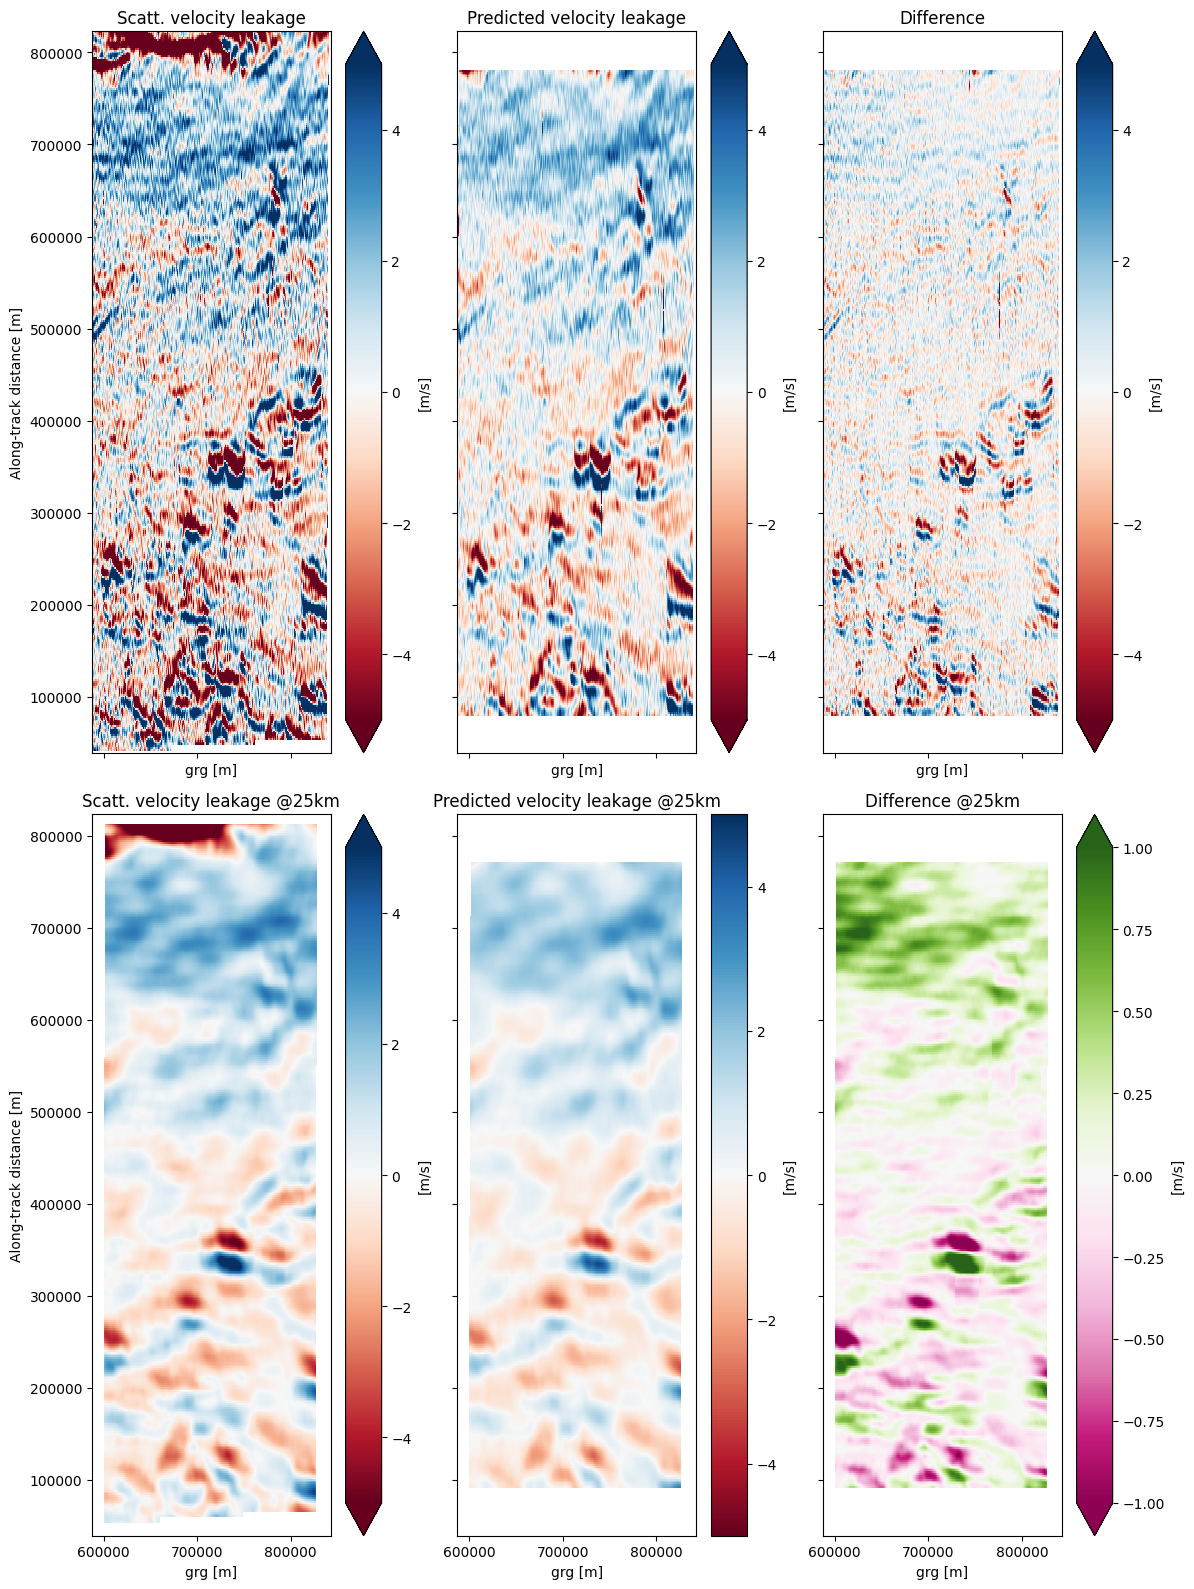

In [36]:
fig, axes = plt.subplots(2, 3, figsize=(12, 16), sharex=True, sharey=True)

vmin = -5
vmax = 5

data.V_leakage_pulse_rg.T.plot(robust = True, ax=axes[0,0], vmin=vmin, vmax=vmax, cmap='RdBu', cbar_kwargs={"label": "[m/s]"})
data_inverse.V_leakage_pulse_rg.T.plot(robust = True, ax=axes[0,1], vmin=vmin, vmax=vmax, cmap='RdBu', cbar_kwargs={"label": "[m/s]"})
(data.V_leakage_pulse_rg.T - data_inverse.V_leakage_pulse_rg.T).plot(robust = True, ax=axes[0,2], vmin=vmin, vmax=vmax,cmap='RdBu', cbar_kwargs={"label": "[m/s]"})

axes[0,0].set_ylabel('Along-track distance [m]')
axes[0,1].set_ylabel('')
axes[0,2].set_ylabel('')
axes[0,0].set_title('Scatt. velocity leakage')
axes[0,1].set_title('Predicted velocity leakage')
axes[0,2].set_title('Difference')

data.V_leakage_pulse_rg_subscene.T.plot(robust = True, ax=axes[1,0], vmin=vmin, vmax=vmax, cmap='RdBu', cbar_kwargs={"label": "[m/s]"})
data_inverse.V_leakage_pulse_rg_subscene.T.plot(robust = True, ax=axes[1,1], vmin=vmin, vmax=vmax, cmap='RdBu', cbar_kwargs={"label": "[m/s]"})
(data.V_leakage_pulse_rg_subscene.T - data_inverse.V_leakage_pulse_rg_subscene.T).plot(robust = True, ax=axes[1,2], vmin=vmin/5, vmax=vmax/5,cmap='PiYG', cbar_kwargs={"label": "[m/s]"})

axes[1,0].set_ylabel('Along-track distance [m]')
axes[1,1].set_ylabel('')
axes[1,2].set_ylabel('')
axes[1,0].set_title('Scatt. velocity leakage @25km')
axes[1,1].set_title('Predicted velocity leakage @25km')
axes[1,2].set_title('Difference @25km')

fig.tight_layout()

Text(0, 0.5, 'Along-track distance [m]')

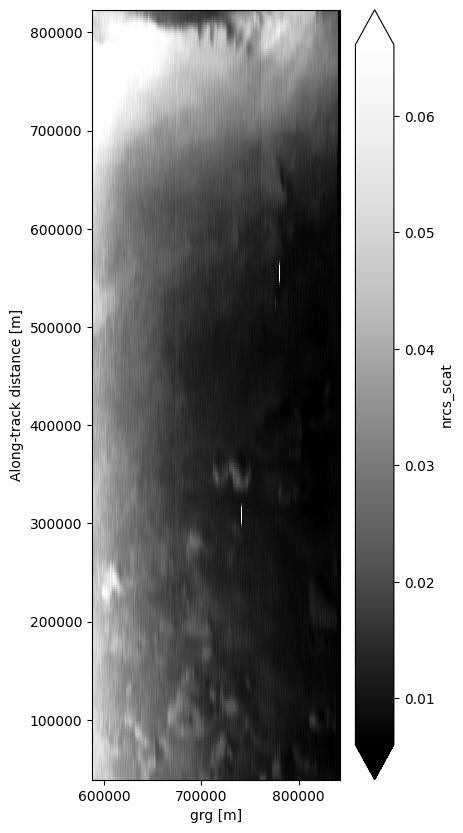

In [38]:
data.nrcs_scat.T.plot(robust=True, cmap= 'Greys_r', figsize=(4,10), aspect='auto')
plt.ylabel('Along-track distance [m]')

### All scenes 

In [18]:
data_dir = "/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/"
data_type = "4ML_phased_array_la3dot2_vxsat8000_PRF4_resspa100.nc"
scenarios = glob.glob(f"{data_dir}*{data_type}")
scenarios.sort()
scenarios

['/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Azores_20201127_4ML_phased_array_la3dot2_vxsat8000_PRF4_resspa100.nc',
 '/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Barbedos_20201110_4ML_phased_array_la3dot2_vxsat8000_PRF4_resspa100.nc',
 '/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Carrib_20231104_4ML_phased_array_la3dot2_vxsat8000_PRF4_resspa100.nc',
 '/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Hawaii_20201106_4ML_phased_array_la3dot2_vxsat8000_PRF4_resspa100.nc',
 '/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Iceland_20231107_4ML_phased_array_la3dot2_vxsat8000_PRF4_resspa100.nc',
 '/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Morroco_20201103_4ML_phased_array_la3dot2_vxsat8000_PRF4_resspa100.nc',
 '/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Scotland_2

In [17]:
for scenario in scenarios:
    dir_sinc = scenario.replace("phased_array", "sinc")
    dir_sinc_inv = scenario.replace("phased_array", "inverse_sinc")
    dir_phased_array = scenario
    dir_phased_array_inv = scenario.replace("phased_array", "inverse_phased_array")


    data_phased_array = xr.open_dataset(dir_phased_array).V_leakage_pulse_rg_subscene
    data_sinc = xr.open_dataset(dir_sinc).V_leakage_pulse_rg_subscene
    data_inversed_phased_array = xr.open_dataset(dir_phased_array_inv).V_leakage_pulse_rg_subscene
    data_inversed_sinc = xr.open_dataset(dir_sinc_inv).V_leakage_pulse_rg_subscene

    diff_phased_array = data_phased_array - data_inversed_phased_array
    diff_sinc = data_sinc - data_inversed_sinc

    perf_phased_array = np.sqrt(np.nanmean(diff_phased_array**2)), np.nanmedian(diff_phased_array)
    perf_sinc = np.sqrt(np.nanmean(diff_sinc**2)), np.nanmedian(diff_sinc)

    print(f"sinc,   RMSE: {perf_sinc[0]:.3f} m/s, median error: {perf_sinc[1]:.3f} m/s")
    print(f"phased, RMSE: {perf_phased_array[0]:.3f} m/s, median error: {perf_phased_array[1]:.3f} m/s")
    

sinc,   RMSE: 0.304 m/s, median error: 0.037 m/s
phased, RMSE: 0.460 m/s, median error: 0.057 m/s
sinc,   RMSE: 0.183 m/s, median error: 0.023 m/s
phased, RMSE: 0.284 m/s, median error: 0.035 m/s
sinc,   RMSE: 0.189 m/s, median error: 0.004 m/s
phased, RMSE: 0.294 m/s, median error: 0.003 m/s
sinc,   RMSE: 0.223 m/s, median error: -0.006 m/s
phased, RMSE: 0.346 m/s, median error: -0.008 m/s
sinc,   RMSE: 0.228 m/s, median error: -0.003 m/s
phased, RMSE: 0.347 m/s, median error: -0.007 m/s
sinc,   RMSE: 0.208 m/s, median error: -0.016 m/s
phased, RMSE: 0.313 m/s, median error: -0.021 m/s
sinc,   RMSE: 0.298 m/s, median error: -0.001 m/s
phased, RMSE: 0.453 m/s, median error: 0.004 m/s


In [19]:
for scenario in scenarios:
    dir_sinc = scenario.replace("phased_array", "sinc")
    dir_sinc_inv = scenario.replace("phased_array", "inverse_sinc")
    dir_phased_array = scenario
    dir_phased_array_inv = scenario.replace("phased_array", "inverse_phased_array")


    data_phased_array = xr.open_dataset(dir_phased_array).V_leakage_pulse_rg_subscene
    data_sinc = xr.open_dataset(dir_sinc).V_leakage_pulse_rg_subscene
    data_inversed_phased_array = xr.open_dataset(dir_phased_array_inv).V_leakage_pulse_rg_subscene
    data_inversed_sinc = xr.open_dataset(dir_sinc_inv).V_leakage_pulse_rg_subscene

    diff_phased_array = data_phased_array - data_inversed_phased_array
    diff_sinc = data_sinc - data_inversed_sinc

    perf_phased_array = np.sqrt(np.nanmean(diff_phased_array**2)), np.nanmedian(diff_phased_array)
    perf_sinc = np.sqrt(np.nanmean(diff_sinc**2)), np.nanmedian(diff_sinc)

    print(f"sinc,   RMSE: {perf_sinc[0]:.3f} m/s, median error: {perf_sinc[1]:.3f} m/s")
    print(f"phased, RMSE: {perf_phased_array[0]:.3f} m/s, median error: {perf_phased_array[1]:.3f} m/s")
    

sinc,   RMSE: 0.301 m/s, median error: 0.040 m/s
phased, RMSE: 0.457 m/s, median error: 0.061 m/s
sinc,   RMSE: 0.182 m/s, median error: 0.022 m/s
phased, RMSE: 0.282 m/s, median error: 0.034 m/s
sinc,   RMSE: 0.187 m/s, median error: 0.004 m/s
phased, RMSE: 0.290 m/s, median error: 0.003 m/s
sinc,   RMSE: 0.219 m/s, median error: -0.005 m/s
phased, RMSE: 0.341 m/s, median error: -0.008 m/s
sinc,   RMSE: 0.227 m/s, median error: -0.002 m/s
phased, RMSE: 0.346 m/s, median error: -0.005 m/s
sinc,   RMSE: 0.206 m/s, median error: -0.015 m/s
phased, RMSE: 0.310 m/s, median error: -0.021 m/s
sinc,   RMSE: 0.296 m/s, median error: -0.003 m/s
phased, RMSE: 0.450 m/s, median error: 0.002 m/s
